In [278]:
import pandas as pd
import seaborn as sns
import patsy
import networkx as nx
from networkx.readwrite.graphml import read_graphml
from networkx.algorithms.shortest_paths.generic import shortest_path_length
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype']='none'
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
from glob import glob

## Gather results for different scenarios

In [17]:
## a more streamlined implementation of the function in the attractors script
def attractors_1state_from_txt(txt_name, network_name, cleanup=True):
    with open(network_name+'.bnet',encoding='utf-8') as fo:
        nodes_bnet = [ln.strip().split(',')[0] for ln in fo]
    with open(network_name+'.cnet',encoding='utf-8') as fo:
        ln0=fo.readline()
    ln0 = ln0.replace('\n', "").replace('#', "").strip()
    nodes_cnet = ln0.split(', ')
    idx = pd.Series(dict([(vv,kk) for kk,vv in enumerate(nodes_cnet)])).loc[nodes_bnet]
    attractors = list()
    with open(txt_name,encoding='utf-8') as fo:
        p=fo.readlines()
    current_attractor = []
    sizes = []
    for line in p[1:]:
        # Strip line
        cleanline = line.strip().replace('\n', "")
        #print("{:d}: '{:s}'".format(i ,cleanline))
        if cleanline.startswith('Attractor'):
            attractors.append(current_attractor[0])
            current_attractor = []
            size = cleanline[-1]            
            sizes.append(size)
        elif 'average' in cleanline:
            pass
        elif len(cleanline) > 0 and cleanline.startswith(('0','1')):
            cleanline = np.array([int(elt) for elt in cleanline])
            current_attractor.append(cleanline)
    attractors = np.c_[attractors].astype(int)[:,idx.values]
    return pd.DataFrame(attractors,columns=idx.index,index=range(1,attractors.shape[0]+1))
    #np.savetxt('./attfiles/1st_%s.csv' % (network_name.split('/')[-1]), attractors, delimiter = ',') 
    #return attractors


In [282]:
## file for getting all of the attractor data
irrev_d = {}
avgstate_d = {}
numattr_d = {}
for aa,pt in enumerate(['KO','OE']):
    for bb,srt in enumerate(['asc','desc']):
        fn_l = glob("./results/result-%s-twoparam_*_*_%s_*.csv" % (pt,srt))
        for fn in fn_l:
            __,ss,rr,__,rep,__ = fn.split('/')[-1].split('_')
            att_fn = "./attfiles/att_twoparam_%s_%s_%s_%s_%d.txt" % (ss,rr,srt,rep,int(rep))
            net_name = "./netfiles/twoparam_%s_%s_%s_%s_%d" % (ss,rr,srt,rep,int(rep))
            attractors_df = attractors_1state_from_txt(att_fn,net_name) ## data frame of the attractors
            results = pd.read_csv("./results/result-%s-twoparam_%s_%s_%s_%s_%d-pre.csv" % (pt,ss,rr,srt,rep,int(rep)),index_col=0)
            if attractors_df.shape[0]==results.shape[0]:
                results = results.loc[attractors_df.index]
            irrev_d[(srt,pt,ss,rr,rep)] = results.mean(axis=0)
            if pt=='KO': ## this does not depend on the perturbation type
                avgstate_d[(srt,ss,rr,rep)] = attractors_df.mean(axis=0)
                numattr_d[(srt,ss,rr,rep)] = attractors_df.shape[0]
            ## analysis for crp:
            ##


In [28]:
## unit test to confirm that the attractors match 
##     for knockouts, everywhere that there is a "0" in the attractor with have an NaN entry in the irreversibility
for nn,row in results.loc[:257,attractors_df.columns].iterrows():
    if nn>256:
        continue
    inds1 = np.where(row.isna())[0]
    inds2 = np.where(attractors_df.loc[nn]==0)[0]
    if not np.all(inds1==inds2):
        break
else:
    print("Test passed")

Test passed


In [115]:
ppairs_l = []
for kk in irrev_d.keys():
    ppairs_l.append((kk[-3],kk[-2]))


In [68]:
## this list of genes is the set that are potentially irreversible
selg=['crp','phoB','hns','cra','fis','leuO','fnr',
     'rhaS','gadE','rhaR','bglJ','galS','lrp',
     'fur','rcsB','galR','stpA','arcA','gadX','fliZ',
     'cspA','uxuR','gadW','ydeO','xylR','exuR','mlrA',
     'fhlA','oxyR','soxS','rcsA','evgA','srlR','marR',
     'rob','narL','adiY','dcuR','soxR','ptsG','csgD',
     'mazE','flhC','mlc','flhD','mazF','ompR','gutM',
     'yjjQ','marA','hdfR']

In [252]:
## some functions for generating the analysis figures
plt.rcParams['svg.fonttype']='none'
def output_results_by_rep(srt,ss,rr,selg,state_df,irrev_df,numattr_ser):
    fig,ax_l = plt.subplots(2,1,figsize=(6.4,4.8))
    img = ax_l[0].imshow(irrev_df.loc[selg,:].sort_index(axis=1).T,norm='log',vmin=1e-3,vmax=1)
    cb1 = fig.colorbar(img,ax=ax_l[0],orientation='horizontal',location='top')
    cb1.set_label('Irreversibility',size=8)
    plt.setp(cb1.ax.xaxis.get_ticklabels(),size=6)
    ax_l[0].set_yticks(np.arange(irrev_df.shape[1]))
    ax_l[0].set_yticklabels(['%d' % ii for ii in numattr_ser.sort_index().values],size=6)
    ax_l[0].set_ylabel('Rep',size=8)
    ax_l[0].set_xticks(np.arange(51))
    ax_l[0].set_xticklabels(['' for ii in np.arange(51)],size=6,rotation=90, horizontalalignment='center')


    img2 = ax_l[1].imshow(state_df.loc[selg,:].sort_index(axis=1).T)
    cb2 = fig.colorbar(img2,ax=ax_l[1],orientation='horizontal',location='top')
    cb2.set_label('"On" probability',size=8)
    plt.setp(cb2.ax.xaxis.get_ticklabels(),size=6)
    ax_l[1].set_yticks(np.arange(state_df.shape[1]))
    ax_l[1].set_yticklabels(['%d' % ii for ii in numattr_ser.sort_index().values],size=6)
    ax_l[1].set_xticks(np.arange(51))
    ax_l[1].set_xticklabels(selg,size=6,rotation=90, horizontalalignment='center')
    ax_l[1].set_ylabel('Rep',size=8)
    fig.suptitle('Parameters: %s   s=%s   r=%s' % (srt,ss,rr),size=10)
    #plt.tight_layout()
    fig.savefig('accessory_figs/%s_%s_%s.png' % (srt,ss,rr))
    return

def convergence_plots(srt,ss,rr,summary_l):
    fig,ax_l=plt.subplots(2,1,sharex=True)
    L = len(summary_l)
    clr_d = {'irrev':'C0','state':'C1','N_A':'C2'}
    off_d = {'irrev':-.01,'state':0,'N_A':.01}
    for stat in ['rmsd','max']:
        LS= '-' if stat=='rmsd' else '--'
        for kw in ['irrev','state','N_A']:
            clr = clr_d[kw]
            offset= off_d[kw]
            xvals = np.arange(1,L+1)+offset
            if stat=='max' and kw=='N_A':
                continue
            yvals = np.asarray([np.mean(np.abs(summary_l[ii][(kw,stat)])) for ii in range(L)])
            yv975 = np.asarray([SAP(np.abs(summary_l[ii][(kw,stat)]),97.5) for ii in range(L)])
            yv025 = np.asarray([SAP(np.abs(summary_l[ii][(kw,stat)]),2.5) for ii in range(L)])
            yerr = np.c_[yvals-yv025,yv975-yvals].T
            if kw!='N_A':
                ax_l[1].errorbar(xvals,yvals,yerr,fmt='.%s%s' % (clr,LS),label='%s %s' % (stat,kw))
            else:
                ax_l[0].errorbar(xvals,yvals,yerr,fmt='.%s%s' % (clr,LS),label='%s %s' % (stat,kw))
    ax_l[0].legend(frameon=False,ncol=1,title='Quantity')
    ax_l[1].legend(frameon=False,ncol=2,title='Quantity')
    for ii in range(2):
        ax_l[ii].set_ylabel('Difference')

    ax_l[1].set_xlabel('Number of replicates')
    ax_l[1].set_ylim(0,1.1)
    ax_l[1].set_xlim(0.8,5.2)
    ax_l[1].set_xticks(np.arange(1,L+1))
    fig.suptitle('Parameters: %s   s=%s   r=%s' % (srt,ss,rr),size=10)
    fig.savefig('accessory_figs/convergence_%s_%s_%s.png' % (srt,ss,rr))
    return

In [276]:
from itertools import combinations as combs
from scipy.stats import gmean,scoreatpercentile as SAP
from collections import defaultdict

## additional analysis functions
def analyze_replicates(df_d,selg):
    nn_l = []
    ELT0 = list(df_d.values())[0]
    L = ELT0.shape[1]
    for nn in range(int(L/2)+1):
        print(nn)
        if nn<1:
            continue
        output_dd = defaultdict(list)
        for ncmb in combs(ELT0.columns,nn):
            unsel = set(ELT0.columns)-set(ncmb)
            nmu_d = dict([(kw,df.loc[selg,ncmb].mean(axis=1)) if isinstance(df,pd.DataFrame) else (kw,gmean(df.loc[list(ncmb)])) for kw,df in df_d.items()])
            for mcmb in combs(unsel,nn):
                for kw,df in df_d.items():
                    cmp = df.loc[selg,mcmb].mean(axis=1) if isinstance(df,pd.DataFrame) else gmean(df.loc[list(mcmb)])
                    if isinstance(df,pd.DataFrame):
                        output_dd[(kw,'rmsd')].append(np.sqrt(np.mean(np.square(nmu_d[kw]-cmp))))
                        output_dd[(kw,'max')].append(np.amax(np.abs(nmu_d[kw]-cmp)))
                    else:
                        output_dd[(kw,'rmsd')].append(np.abs(nmu_d[kw]-cmp))
        nn_l.append(dict(output_dd))
    return nn_l

def analyze_irr_sets(irrev):
    isIrrev = irrev>0
    irr_gns = irrev[(isIrrev).any(axis=1)].index
    nn_l = []
    for nn in range(int(irrev.shape[1])):
        print(nn)
        if nn<1:
            continue
        ovr_l = []
        for ncmb in combs(irrev.columns,nn):
            cmb_irr_gns = irrev[isIrrev.loc[:,ncmb].any(axis=1)].index
            ovr = len(set(irr_gns) & set(cmb_irr_gns))
            ovr_l.append(ovr/len(irr_gns))
        nn_l.append(ovr_l)
    return nn_l

def convergence_igs(srt,ss,rr,nn_l):
    fig,ax=plt.subplots(1,1)
    L = len(nn_l)
    #clr_d = {'irrev':'C0','state':'C1','N_A':'C2'}
    #off_d = {'irrev':-.01,'state':0,'N_A':.01}
    LS='-'    
    xvals = np.arange(1,L+1)
    yvals = np.asarray([np.mean(np.abs(nn_l[ii])) for ii in range(L)])
    yv975 = np.asarray([SAP(np.abs(nn_l[ii]),97.5) for ii in range(L)])
    yv025 = np.asarray([SAP(np.abs(nn_l[ii]),2.5) for ii in range(L)])
    yerr = np.c_[yvals-yv025,yv975-yvals].T
    ax.errorbar(xvals,yvals,yerr,fmt='.C0%s' % (LS))
    ax.set_ylabel('Fraction recovered')
    ax.set_xlabel('Number of replicates')
    ax.set_ylim(0,1.1)
    ax.set_xlim(0.8,L+.2)
    ax.set_xticks(np.arange(1,L+1))
    fig.suptitle('Parameters: %s   s=%s   r=%s' % (srt,ss,rr),size=10)
    fig.savefig('accessory_figs/irr_overlap_%s_%s_%s.png' % (srt,ss,rr))
    return

#stat_df = state_df if isState else irrev_df
#summary_l = analyze_replicates({'irrev':irrev_df,'state':state_df,'N_A':numattr_ser},selg)

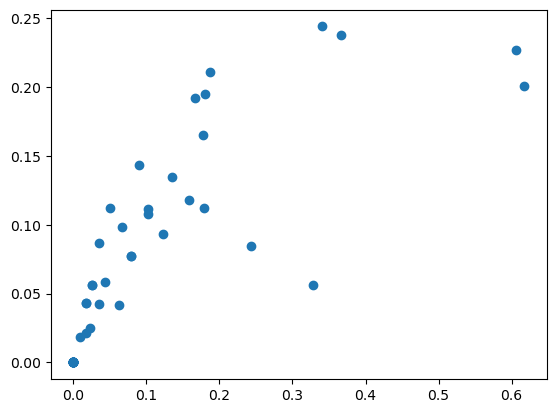

In [163]:
## not currently used, leaving in case we want to bring it back
# from sklearn.model_selection import ShuffleSplit,LeaveOneOut
# rs = ShuffleSplit(n_splits=9, test_size=3)
#loo = LeaveOneOut()
# diff_d = {}
#for ii, (train_index, test_index) in enumerate(loo.split(irrev_df.columns)):
# for ii, (train_index, test_index) in enumerate(rs.split(irrev_df.columns)):
#     diff = irrev_df.loc[selg,train_index].mean(axis=1)-irrev_df.loc[selg,test_index].mean(axis=1)
#     diff_d[''.join(['%d' % elt for elt in test_index])] = diff
# stds = pd.concat(diff_d,axis=1).apply(np.square).sum(axis=1).apply(np.sqrt)
# mus = irrev_df.loc[selg,:].mean(axis=1)
# plt.scatter(mus,stds/3)

#### Loop to analyze the results -- need to include old data as well, eventually

0
1
2
3
4
5
asc 0.80 1.00
0
1
2
3
4
5
6
7
8
9
desc 0.80 1.00
0
1
2
3
4
5
6
asc 0.60 0.40
0
1
2
3
4
5
6
7
8
9
desc 0.60 0.40
0
1
2
3
4
5
6
7
8
9
asc 0.60 1.00
0
1
2
3
4
5
6
7
8
9
desc 0.60 1.00
0
1
2
3
4
5
6
asc 0.40 0.60
0
1
2
3
4
5
6
7
8
9
desc 0.40 0.60
0
1
asc 0.80 0.20
0
1
2
3
4
5
6
7
8
9
desc 0.80 0.20
0
1
2
3
4
5
6
7
8
asc 0.20 1.00
0
1
2
3
4
5
6
7
8
9
desc 0.20 1.00
0
1
2
3
asc 0.40 1.00
0
1
2
3
4
5
6
7
8
9
desc 0.40 1.00
0
1
2
3
4
5
6
7
8
asc 0.20 0.80
0
1
2
3
4
5
6
7
8
9
desc 0.20 0.80


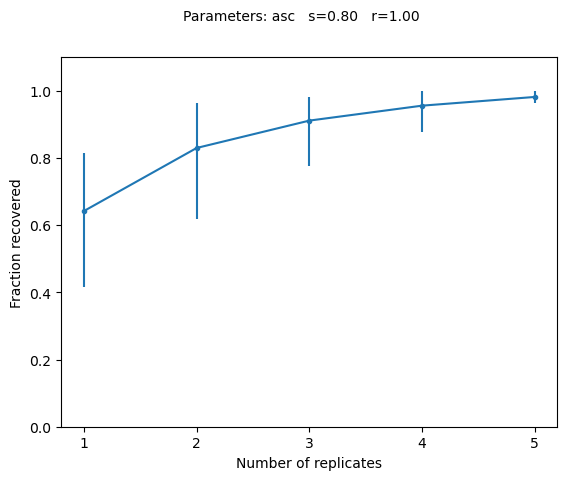

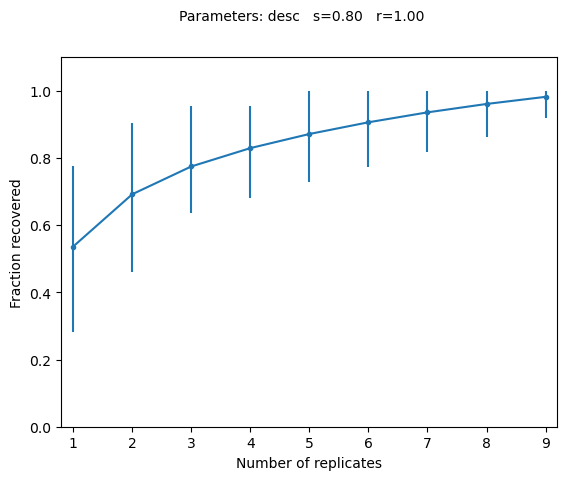

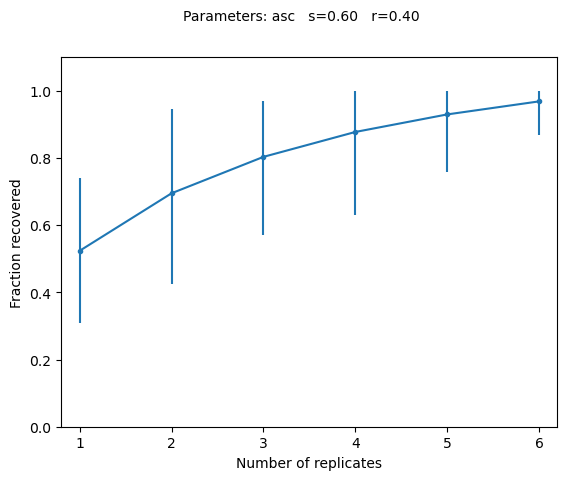

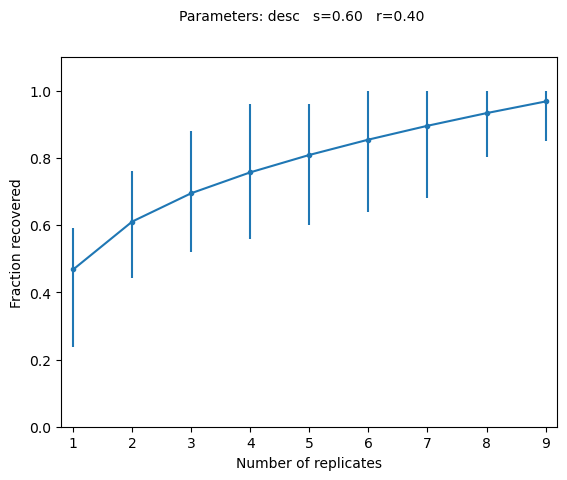

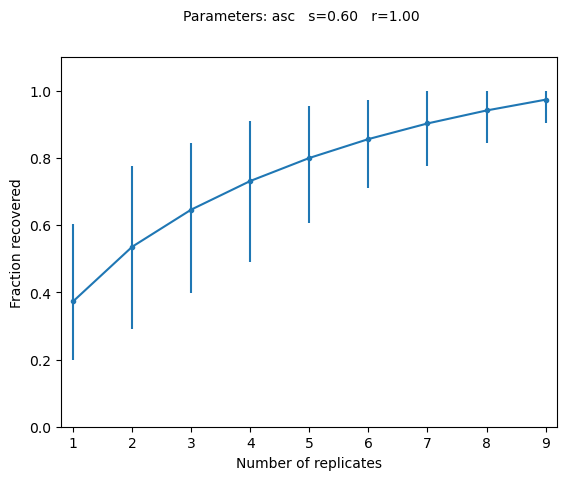

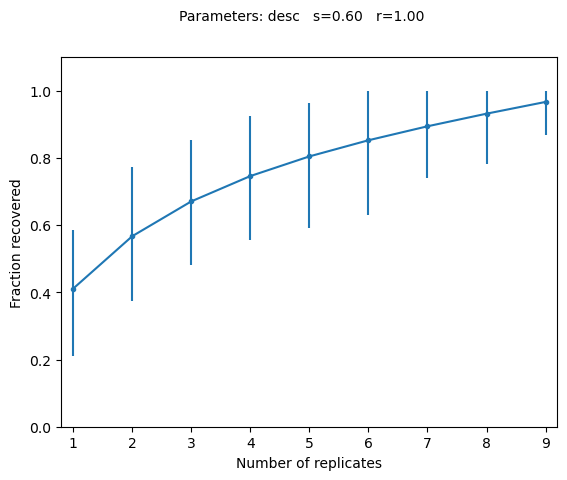

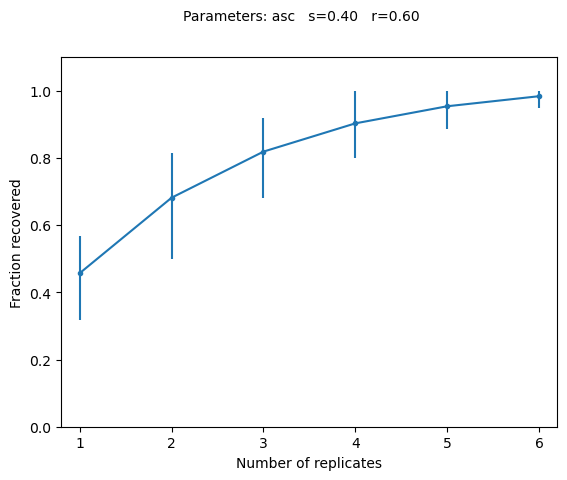

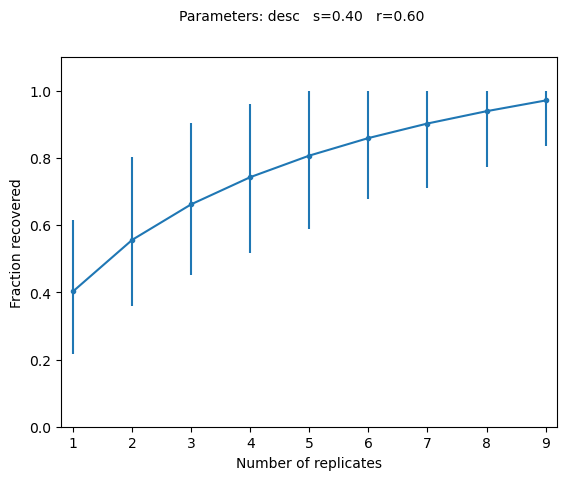

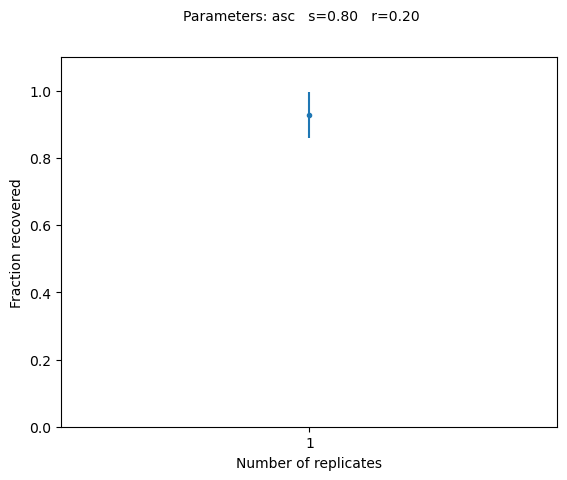

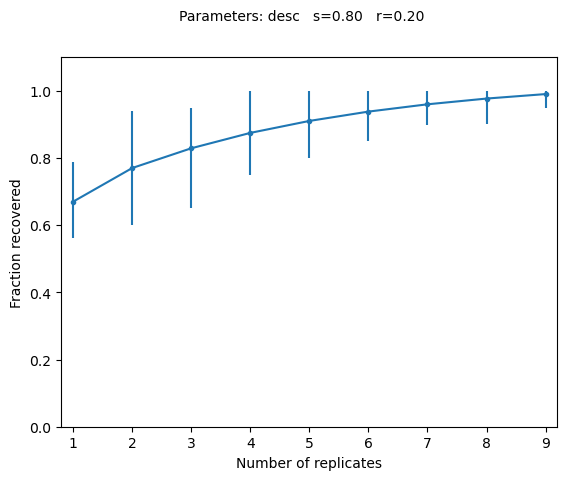

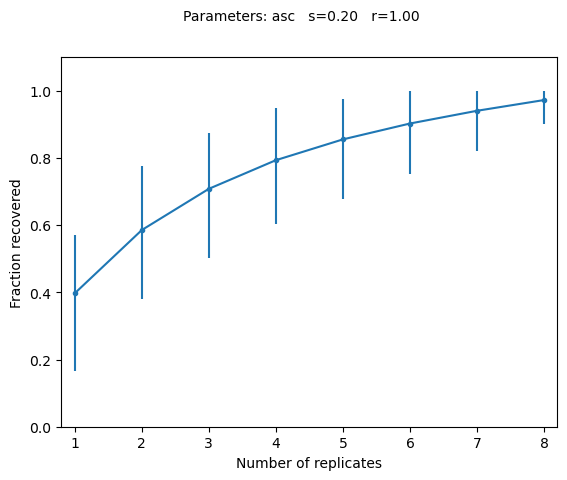

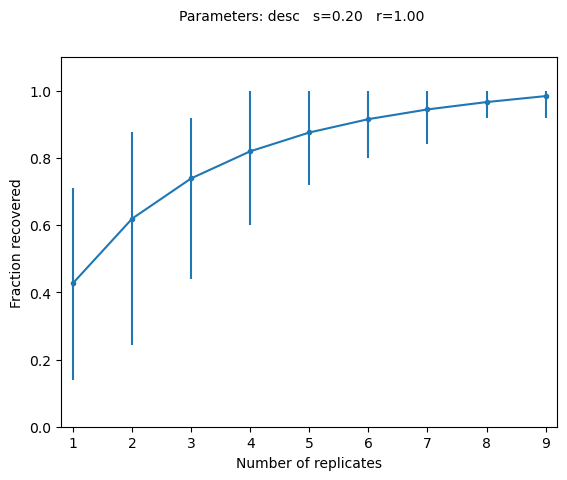

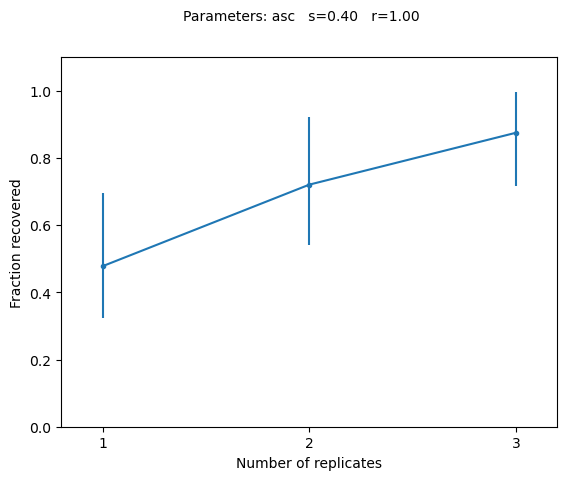

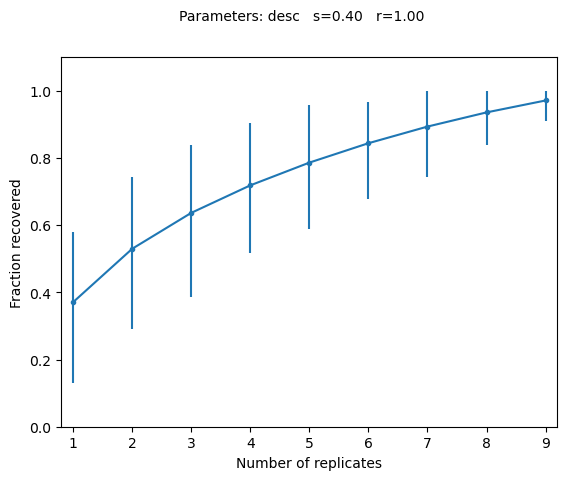

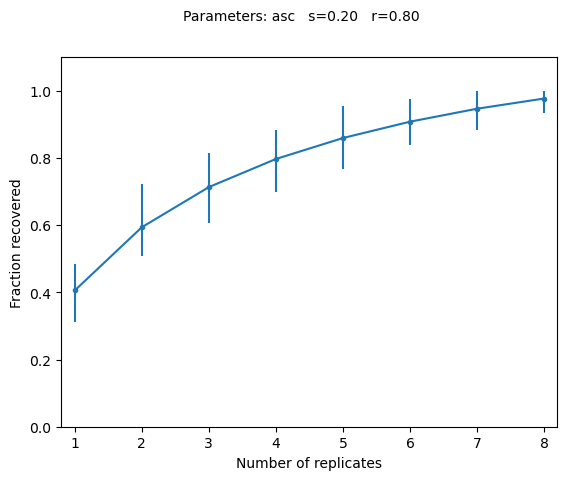

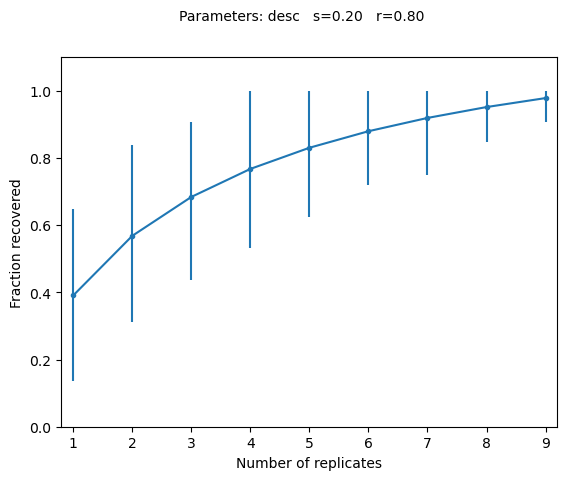

In [277]:
## may need to include results on earlier data...
for (ss,rr) in set(ppairs_l):
    for srt in ['asc','desc']:
        sel_keys = [kk for kk in irrev_d.keys() if kk[0]==srt and kk[1]=='KO' and kk[2]==ss and kk[3]==rr]
        rep_irrev_d = {}
        rep_state_d = {}
        rep_numattr_d = {}
        for sk in sel_keys:
            srt,pt,ss,rr,rep = sk
            okey = (srt,'OE',ss,rr,rep)
            avg_key = (srt,ss,rr,rep)
            ptirrev_df = pd.concat({'KO':irrev_d[sk],'OE':irrev_d[okey]},axis=1)
            state = avgstate_d[avg_key]
            num = numattr_d[avg_key]
            avg_irrev = pd.concat({'KD':(ptirrev_df.KO*state),'OE':(1-state)*ptirrev_df.OE},axis=1).mean(axis=1)
            rep_irrev_d[int(rep)]=avg_irrev
            rep_state_d[int(rep)]=state
            rep_numattr_d[int(rep)] = num
        irrev_df=pd.DataFrame(rep_irrev_d)
        state_df = pd.DataFrame(rep_state_d)
        numattr_ser = pd.Series(rep_numattr_d)
        output_results_by_rep(srt,ss,rr,selg,state_df,irrev_df,numattr_ser)
        summary_l = analyze_replicates({'irrev':irrev_df,'state':state_df,'N_A':numattr_ser},selg)
        nn_l = analyze_irr_sets(irrev_df)
        print(srt,ss,rr)
        convergence_plots(srt,ss,rr,summary_l)
        convergence_igs(srt,ss,rr,nn_l)
        

Text(0.5, 1.0, 'Negligible impact of perturbation class')

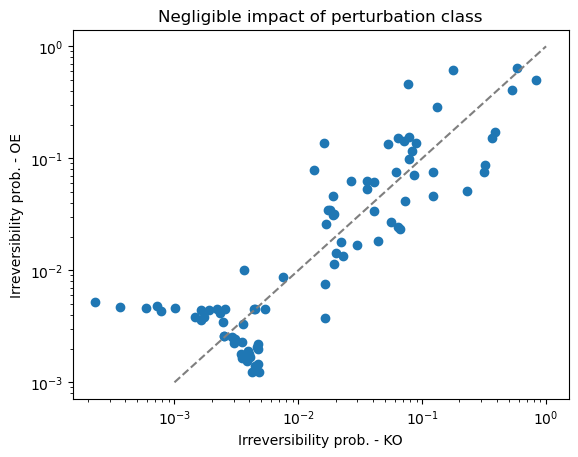

In [288]:
## KO vs OE
KOvsOE = pd.DataFrame(irrev_d).T.groupby(level=1).mean()
plt.scatter(KOvsOE.loc['KO'],KOvsOE.loc['OE'])
plt.plot(np.logspace(-3,0),np.logspace(-3,0),ls='--',color='C7')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('Irreversibility prob. - KO')
plt.gca().set_ylabel('Irreversibility prob. - OE')
plt.gca().set_title('Negligible impact of perturbation class')

Text(0.5, 1.0, 'Input sorting impacts irreversibility')

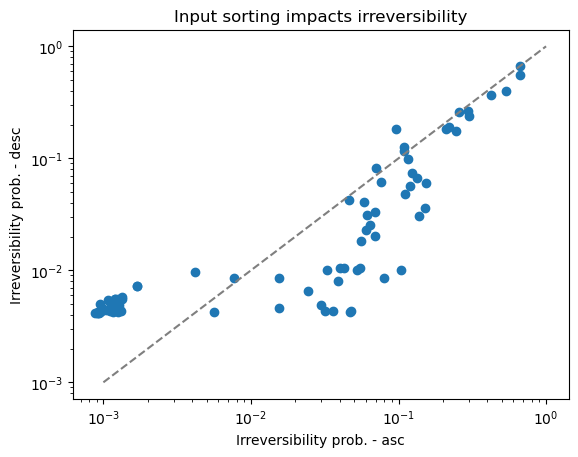

In [290]:
ascvsdesc = pd.DataFrame(irrev_d).T.groupby(level=0)
plt.scatter(ascvsdesc.loc['asc'],ascvsdesc.loc['desc'])
plt.plot(np.logspace(-3,0),np.logspace(-3,0),ls='--',color='C7')
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().set_xlabel('Irreversibility prob. - asc')
plt.gca().set_ylabel('Irreversibility prob. - desc')
plt.gca().set_title('Input sorting impacts irreversibility')

## Graphml file for Fig. 3 

In [2]:
mus_l = []
for aa,pt in enumerate(['KO','OE']):
    for bb,srt in enumerate(['asc','desc']):
        
        results = pd.read_csv("./results/result-%s-twoparam_%s.csv" % (pt,srt),index_col=0)
        ## load the state (oe/kd) frequencies
        states = pd.read_csv("./results/states_neg2_pre_%s_%s.csv" % (pt,srt),index_col=0)
        ## The MultiIndex allows us to easily take a statistics over a fixed value of the parameters.
        results.index = pd.MultiIndex.from_tuples([e.split('-') for e in results.index])
        states.index = pd.MultiIndex.from_tuples([e.split('-') for e in states.index])
        ## With the multiindex and groupby functionality, 
        ## we can condense the "weighted_mean" functions into a single line
        mus_l.append(((results*states).groupby(level=0).sum()/states.groupby(level=0).sum()).mean(axis=0))
        
ovr_avg = pd.concat(mus_l,axis=1).mean(axis=1).sort_values(ascending=False)   
ovr_avg = dict(ovr_avg)
G_rs2 = nx.read_gml('./networks/rs2.gml')
nodes_rs2 = list(G_rs2.nodes())
nodes_all = list(ovr_avg.keys())
irr_all = list(ovr_avg.values())
for i in nodes_rs2:
    if i not in nodes_all:
        nodes_all.append(i)
        irr_all.append(0)
overall = dict(zip(nodes_all,irr_all))

nx.set_node_attributes(G_rs2, dict(zip(list(ovr_avg.keys()),np.log10(list(ovr_avg.values())))), 'logIrrFreq2')
nx.set_node_attributes(G_rs2, dict(zip(nodes_all,nodes_all)), 'name')
nx.write_gml(G_rs2, './networks/rs2_irr_neg2_newx.gml')
nx.write_graphml(G_rs2, './networks/rs2_irr_neg2_newx.graphml') 

In [3]:
((results*states).groupby(level=0).sum()/states.groupby(level=0).sum())

,crp,hns,fnr,fis,rcsB,arcA,fur,cra,phoB,soxS,...,xylR,mazE,uxuR,galS,exuR,mazF,cspA,flhD,flhC,dcuR
0,0.932901,0.530055,0.343966,0.379808,0.165278,0.171781,0.266915,0.632243,0.686177,0.168920,...,0.000000,0.000000,0.285662,0.125523,0.070522,0.000000,0.011628,0.000000,0.035978,0.000000
0.2,0.974801,0.637679,0.583570,0.372870,0.390026,0.160327,0.183919,0.617028,0.732208,0.107415,...,0.150943,0.000000,0.197775,0.677352,0.080694,0.000000,0.000228,0.016129,0.000000,0.151801
0.4,0.867104,0.000000,0.409314,0.000000,0.164677,0.100905,0.321673,0.361365,0.762571,0.000000,...,0.000000,0.000000,0.094176,0.029403,0.033251,0.000000,0.000000,NaN,0.000000,0.000000
0.6,0.998247,0.569598,0.469002,0.380589,0.371408,0.206373,0.394050,0.407752,0.699678,0.000000,...,0.000000,0.242195,0.246083,0.616667,0.112036,0.242195,0.239497,0.000000,0.000000,0.000000
0.8,0.911379,0.000000,0.235421,0.082938,0.199275,0.110659,0.000000,0.396684,0.767525,0.000000,...,NaN,NaN,0.394349,0.174292,0.075895,0.000000,0.000000,0.000000,0.000000,0.000000
1,NaN,NaN,0.000000,NaN,0.500000,0.000000,NaN,0.000000,0.750000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN


## Fig. 4

C:\Users\gris_\AppData\Local\Temp\ipykernel_28188\2592031394.py:59: RuntimeWarning: invalid value encountered in true_divide
  mean = np.sum(weighted_data[i*exp:(i+1)*exp,:],axis=0)/np.sum(states[i*exp:(i+1)*exp,:],axis=0)
C:\Users\gris_\anaconda3\lib\site-packages\seaborn\matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\gris_\anaconda3\lib\site-packages\seaborn\matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
C:\Users\gris_\AppData\Local\Temp\ipykernel_28188\2592031394.py:59: RuntimeWarning: invalid value encountered in true_divide
  mean = np.sum(weighted_data[i*exp:(i+1)*exp,:],axis=0)/np.sum(states[i*exp:(i+1)*exp,:],axis=0)
C:\Users\gris_\anaconda3\lib\site-packages\seaborn\matrix.py:194: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
C:\Users\gris_\anaconda3\lib\site-packages\seaborn\matrix.py:199: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)
C:

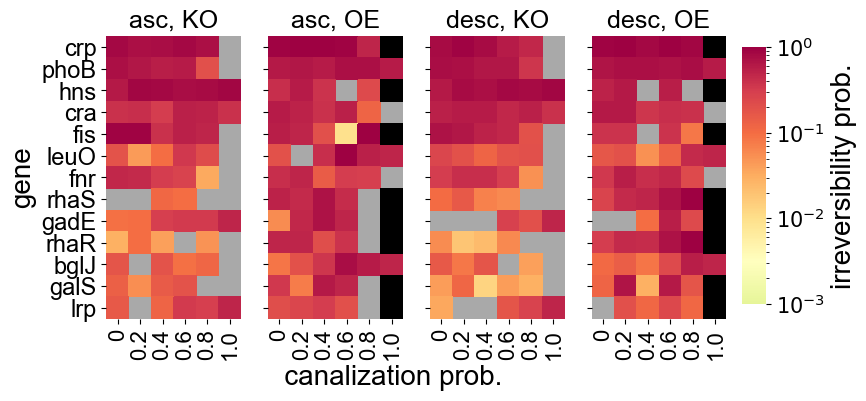

In [37]:
import cmasher as cmr
from matplotlib.patches import Patch
import matplotlib.colors as mcolors


irr_nodes = set()

f, axarr = plt.subplots(1,4, sharex=True, sharey=True,figsize=(8,3.67),facecolor='white')
sns.color_palette("coolwarm_r")


names = ['KO_inv','OE_inv','KO_so','OE_so']
titles = ['asc, KO','asc, OE','desc, KO','desc, OE']
cbs = [False,False,False,False,True]
cbar_ax = f.add_axes([.92, .15, .03, .7])

for n in range(4):
    name = names[n]
    results = pd.read_csv("./results/df_neg2_pre_noNA_"+name+".csv",index_col=0)
    states = pd.read_csv("./results/states_neg2_pre_"+name+".csv",index_col=0)
    nodes = set(list(results.columns))
    irr_nodes = irr_nodes | nodes
irr_nodes = list(dict(ovr_avg).keys())

def get_element_index(ob_list, word_list):
    idx_list = []
    for word in word_list:
        idx = [i for (i, v) in enumerate(ob_list) if v == word]
        idx_list+=idx
    idx_list = list(idx_list)
    idx_list = np.array(list(idx_list))
    return idx_list
def mean_per_realization(data,num_para,exp):
    means = []
    for i in range(num_para):
        data_i = data[i*exp:(i+1)*exp,:]
        data_i = np.ma.masked_array(data_i,[data_i<0])
        mean = np.mean(data_i,axis=0)
        means.append(mean)
    means.append(data[-1,:])
    means = np.array(means)
    return means

def set_na(floatdf,nadf,num_para,exp):
    
    for i in range(num_para):
        for j in range(10):
            mean = np.mean(data[i*exp:(i+1)*exp,:],axis=0)
            means.append(mean)
    means.append(data[-1,:])
    means = np.array(means)
    return means
def weighted_mean(data,states,num_para,exp):
    means = []
    weighted_data = data*states
    for i in range(num_para):
        mean = np.sum(weighted_data[i*exp:(i+1)*exp,:],axis=0)/np.sum(states[i*exp:(i+1)*exp,:],axis=0)
        means.append(mean)
    means.append(weighted_data[-1,:])
    means = np.array(means)
    return means
def num_irr_per_p(data01,num_para):
    nums = []
    data_0101 = data01.copy()
    data_0101[data_0101 > 0] = 1
    for i in range(num_para):
        num = np.sum(data_0101[i,:])
        nums.append(num)
    plt.title('inv')
    plt.xlabel('canalization prob')
    plt.ylabel('num irr nodes')
    
    plt.plot(exps,nums)
    plt.savefig('num_irr_inv.png',dpi=300)
    plt.show()    
    

all_mean = []
for n in range(4):
    name = names[n]
    results = pd.read_csv("./results/df_neg2_pre_noNA_"+name+".csv",index_col=0)
    states = pd.read_csv("./results/states_neg2_pre_"+name+".csv",index_col=0)
    nodes = list(results.columns)
    exps = [0,0.2,0.4,0.6,0.8,1.0]
    
    data = np.array(results.values)
    states = np.array(states.values)
    data_01 = results.copy()
    data[states==0] = -0.0001
        
    mean_float = weighted_mean(data,states,5,10).T
    mean_NA = mean_per_realization(data,5,10).T
    mean_float[mean_NA<-0.0000999] = -0.0001
    
    for i in irr_nodes:
        if i not in nodes:
            mean_float = np.append(mean_float, values=[[0,0,0,0,0,0]], axis=0)
            nodes.append(i)
    
    correct_idx = get_element_index(nodes,irr_nodes)
    mean_float = mean_float[correct_idx,:]
    all_mean.append(mean_float)
    
    df_float = pd.DataFrame(mean_float[:13,:],columns=exps,index=irr_nodes[:13])
    log_norm = LogNorm(vmin=0.001, vmax=1)
    cmap = cmr.get_sub_cmap('Spectral_r', 0.4, 1)
   
    ax = sns.heatmap(df_float,mask=(df_float==0),cbar=True,xticklabels=True, yticklabels=True, norm=log_norm, cbar_kws={"ticks":[1e-3,1e-2,1e-1,1],'label':'irriversibility prob.'},vmin = 0.001, vmax=1,ax=axarr[n],cbar_ax=cbar_ax,cmap=cmap)
    sns.heatmap(df_float, cmap=ListedColormap(['k']), cbar=False, mask=(df_float >=0),ax=ax)
    axarr[n].set_title(titles[n],font = 'Arial',fontsize=18)
    axarr[n].set_facecolor("darkgrey")
    axarr[n].set_xticklabels(exps,font = 'Arial',fontsize=16,rotation=90)
    axarr[n].set_yticklabels(irr_nodes[:13],font = 'Arial',fontsize=17)
    
    axarr[1].set_xlabel('               canalization prob.',font = 'Arial',fontsize=20)
    axarr[0].set_ylabel('gene',font = 'Arial',fontsize=20)
    
cax = plt.gcf().axes[-1]
cax.tick_params(labelsize=15)
cax.set_ylabel('irreversibility prob.',font = 'Arial',fontsize=20)


    #num_irr_per_p(mean_01,6)

f.subplots_adjust(hspace=0)

for ax in axarr:
    ax.label_outer()
    
f.savefig('./figs/fig4.svg',dpi=1200)


## Fig. 5

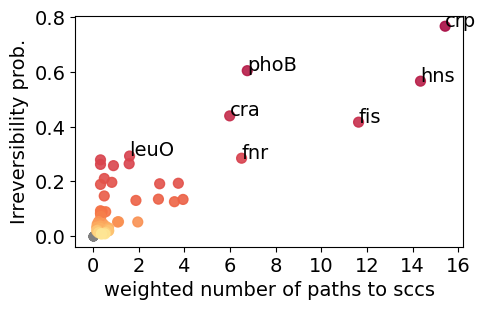

In [40]:

def path_weight(G,path):
    weight = 1
    for node in path[1:]:
        weight *= 1/G.in_degree(node)
    return weight

def path_sign(G,path):
    sign = 1
    for i in range(len(path)-1):
        edge = (path[i],path[i+1])
        sign *= G.get_edge_data(edge[0],edge[1])['weight']
    return sign

#print(list(nx.all_simple_paths(G,'crp','ptsG')))
effect = 0
for path in list(nx.all_simple_paths(G,'crp','ptsG')):
    
    weight = path_weight(G,path)
    sign = path_sign(G,path)
    
    effect += weight*sign
def num_scc_weighted(G,group):
    sccs = list(nx.strongly_connected_components(G))
    num_edge_scc = []
    for n in group:  
        num_edge = 0
        for s in sccs:
            if len(s) == 1 and list(G_rs2.out_edges(list(s)[0],data=True))[0][2]['weight'] == -1:
                continue
            if set(n) != s:
                for n_s in s:
                    if n_s != n:
                        try:
                            length=nx.shortest_path_length(G,source=n,target=n_s)
                            if length == 0:
                                shortest_paths = list(nx.shortest_simple_paths(G,source=n,target=n_s))
                                if len(shortest_paths) != 1:
                                    length = len(shortest_paths[1])
                                else:
                                    continue

                            if length <= max_length:
                                num_edge += 1/length
                                if length == 0:
                                    print(n,n_s)
                                break


                        except nx.NetworkXNoPath:
                            continue
        
        num_edge_scc.append(num_edge)
        
    return num_edge_scc
def num_path_scc_weighted(G,group):
    sccs = list(nx.strongly_connected_components(G))
    num_edge_scc = []
    for n in group:  
        num_edge = 0
        for s in sccs:
            if len(s) == 1 and list(G_rs2.out_edges(list(s)[0],data=True))[0][2]['weight'] == -1:
                continue
            if set(n) != s:
                for n_s in s:
                    if n_s != n:
                        try:
                            paths = list(nx.all_simple_paths(G, n, n_s, cutoff=max_length))
                            
                            for path in paths:

                                weight = path_weight(G,path)
                                sign = path_sign(G,path)

                                num_edge += abs(weight*sign)
                        except nx.NetworkXNoPath:
                            continue
        num_edge_scc.append(abs(num_edge))
    return num_edge_scc  
G_rs2 = nx.read_gml('./networks/rs2.gml')
max_length = 4
nodes = [i for i in overall.keys()]
irr_nodes = nodes
overall = np.array([i[1] for i in overall.items()])

pos_value = overall[:51]
pos_nodes = nodes[:51]

zero_value = overall[51:]
zero_nodes = nodes[51:]

#reached_scc = num_reached_scc(G_rs2,nodes,cutoff)
path_scc_pos = num_path_scc_weighted(G_rs2,pos_nodes)
path_scc_zero = num_path_scc_weighted(G_rs2,zero_nodes)

#scc = num_scc(G_rs2,nodes,cutoff)

plt.figure(figsize=(5,3))
plt.scatter(path_scc_zero,zero_value,c='grey', alpha=0.5)
plt.scatter(path_scc_pos,pos_value,c=np.log10(pos_value),vmin = -5, vmax=0, cmap = 'Spectral_r', alpha=0.9,s=50)
plt.xlabel('weighted number of paths to sccs',fontsize=14)
plt.ylabel('Irreversibility prob.',fontsize=14)
plt.xticks(fontsize=14 )
plt.yticks(fontsize=14 )
for i,txt in zip(get_element_index(nodes, irr_nodes[:7]),irr_nodes[:7]):
     plt.annotate(txt,(path_scc_pos[i],pos_value[i]),fontsize=14)
plt.savefig('./figs/fig5.svg',dpi=1200)
plt.show()



## Fig. S2 (Properties of the rules as a function of $r$ and $s$)

In [ ]:
import sympy
from sympy.abc import r,s
from sympy.logic.boolalg import truth_table
from collections import defaultdict

def generate_possible_rules_probabilities_new(unas,expr='',prob=1,paren=0):
    if len(unas)==1:
        ## termination condition
        expr+=  ('%s '% (unas[0])) +')'*paren
        return [([],expr,prob,0)]
    nexpr1 = expr + ' %s & ( ' % (unas[0])
    nprob1 = prob*r
    nparen1 = paren + 1
    nexpr21 = expr + ' %s | ' % (unas[0])
    nprob21 = prob*(1-r)*s
    nparen21 = paren
    nexpr221 = expr + ' %s & ' % (unas[0])
    nprob221 = prob*(1-r)*(1-s)
    nparen221 = paren
    return generate_possible_rules_probabilities_new(unas[1:],nexpr1,nprob1,nparen1)+ \
           generate_possible_rules_probabilities_new(unas[1:],nexpr21,nprob21,nparen21) + \
           generate_possible_rules_probabilities_new(unas[1:],nexpr221,nprob221,nparen221)

def parse_rule_attrs(rstr, ch='a'):
    L = rstr.split('%s_' % ch)
    cd = 1
    cd_d = defaultdict(list)
    inp_l = []
    for elt in L:
        if elt=='': ## string starts with no parentheses
            continue
        elif elt.startswith('('): ## string starts with parentheses (at most 1)
            cd+=1
        elif '& (' in elt:
            inp_l.append(elt.split(' &')[0])
            cd_d[cd].extend(inp_l)
            inp_l=[]
            cd += elt.count('(')
        elif ') | (' in elt:
            inp_l.append(elt.split(')')[0])
            cd_d[cd].extend(inp_l)
            inp_l=[]
        elif '| (' in elt:
            inp_l.append(elt.split(' |')[0])
            cd_d[cd].extend(inp_l)
            inp_l=[]
            cd +=2
        elif ' | ' in elt: ## this case MUST COME AFTER ') | ('
            ## inp_l will always be empty in this case
            inp_l.append(elt.split(' | ')[0])
            cd_d[cd].extend(inp_l)
            inp_l=[]
        elif ' & ' in elt:
            inp_l.append(elt.split(' & ')[0])
        elif elt.endswith(')'): ## last term
            inp_l.append(elt.split(')')[0])
            cd_d[cd].extend(inp_l)
            inp_l=[]
        else:
            inp_l.append(elt)
            cd_d[cd].extend(inp_l)
            inp_l=[]
    return dict(cd_d)

In [ ]:
## generate the possible rules for networks up to size 10

myexpr_l = []
bias_poly_l = []
for tsz in range(2,8):
    print(tsz)
    avec = sympy.symarray(a,tsz)
    __,RULES,PROBS,__ = zip(*generate_possible_rules_probabilities_new(avec.tolist(),expr='',prob=1,paren=0))
    sympRULES = [sympy.sympify(RR) for RR in RULES]
    rule_cats = pd.Categorical([str(RR) for RR in sympRULES])
    unique_rules = rule_cats.value_counts().index
    rule_prob_l = []
    for RR in unique_rules:
        cd_d = parse_rule_attrs(RR)
        TF = rule_cats==RR
        cPROB = 0
        for ii in range(len(PROBS)):
            if TF[ii]:
                cPROB+=PROBS[ii]
                
        rule_prob_l.append((RR,sympy.simplify(cPROB),cd_d))
    myexpr=0
    bias_l = []
    for expr,prob,cd_d in rule_prob_l:
        TT_df = pd.DataFrame([np.r_[bvars,op==sympy.true] for bvars,op in truth_table(expr,avec)])
        bias = TT_df.iloc[:,-1].sum()
        bias_l.append(bias*prob)
        ## code to calculate the average canalizing depth
        wt_sum = 0
        totL = 0
        for kk,vv in cd_d.items():
            wt_sum += kk*len(vv)
            totL+=len(vv)
        myexpr+=prob*sympy.Rational(wt_sum,totL) ## this now gives the expected canalizing depth
    bias_poly_l.append(sum(bias_l))
    myexpr_l.append(myexpr)
    


#### GENERATE CODE:

In [ ]:
from sympy import pycode
for ii,expr in enumerate(myexpr_l):
    print("def ex_cdepth%d(r,s):\n    return %s"% (ii+2,sympy.simplify(expr)))
    print("")
print("")
print("")
print("")
for ii,bias in enumerate(bias_poly_l):
    print("def ex_bias%d(r,s):\n    return %s"% (ii+2,sympy.simplify(bias)))
    print("")    

#### Paste code into cell below to define the polynomial functions for plotting:

In [ ]:
def ex_cdepth2(r,s):
    return 1

def ex_cdepth3(r,s):
    return -8*r**2*s**2/3 + 2*r**2*s/3 + 16*r*s**2/3 - 10*r*s/3 - 8*s**2/3 + 8*s/3 + 1

def ex_cdepth4(r,s):
    return -r**3*s**3 + 3*r**3*s**2/4 + r**3*s/4 + 3*r**2*s**3 - 13*r**2*s**2/2 - \
           r**2*s/4 - 3*r*s**3 + 43*r*s**2/4 - 4*r*s + s**3 - 5*s**2 + 4*s + 1

def ex_cdepth5(r,s):
    return 2*r**4*s**3/5 - 2*r**4*s/5 - 16*r**3*s**3/5 + 8*r**3*s**2/5 + 8*r**3*s/5 + \
           36*r**2*s**3/5 - 52*r**2*s**2/5 - 11*r**2*s/5 - 32*r*s**3/5 + 16*r*s**2 - \
           21*r*s/5 + 2*s**3 - 36*s**2/5 + 26*s/5 + 1

def ex_cdepth6(r,s):
    return r**5*s**4/6 + r**5*s**3/6 - 5*r**5*s**2/6 + r**5*s/2 - 5*r**4*s**4/3 + \
           13*r**4*s**3/6 + 13*r**4*s**2/6 - 8*r**4*s/3 + 5*r**3*s**4 - 25*r**3*s**3/2 + \
           2*r**3*s**2 + 11*r**3*s/2 - 20*r**2*s**4/3 + 137*r**2*s**3/6 - 35*r**2*s**2/2 - \
           17*r**2*s/3 + 25*r*s**4/6 - 53*r*s**3/3 + 49*r*s**2/2 - 4*r*s - s**4 + 5*s**3 - \
           31*s**2/3 + 19*s/3 + 1

def ex_cdepth7(r,s):
    return -r**6*s**6 + 19*r**6*s**5/7 - 17*r**6*s**4/7 + r**6*s**3/7 + 8*r**6*s**2/7 - \
           4*r**6*s/7 + 6*r**5*s**6 - 123*r**5*s**5/7 + 130*r**5*s**4/7 - 33*r**5*s**3/7 - \
           6*r**5*s**2 + 26*r**5*s/7 - 15*r**4*s**6 + 330*r**4*s**5/7 - 58*r**4*s**4 + \
           187*r**4*s**3/7 + 64*r**4*s**2/7 - 10*r**4*s + 20*r**3*s**6 - 470*r**3*s**5/7 + \
           664*r**3*s**4/7 - 457*r**3*s**3/7 + 25*r**3*s**2/7 + 14*r**3*s - 15*r**2*s**6 + \
           375*r**2*s**5/7 - 601*r**2*s**4/7 + 564*r**2*s**3/7 - 215*r**2*s**2/7 - 78*r**2*s/7 + \
           6*r*s**6 - 159*r*s**5/7 + 286*r*s**4/7 - 346*r*s**3/7 + 261*r*s**2/7 - 24*r*s/7 - \
           s**6 + 4*s**5 - 8*s**4 + 12*s**3 - 101*s**2/7 + 52*s/7 + 1

def ex_bias2(r,s):
    return -2*r*s + 2*s + 1

def ex_bias3(r,s):
    return -2*r**2*s**2 + 2*r**2*s + 4*r*s**2 - 10*r*s - 2*s**2 + 8*s + 1

def ex_bias4(r,s):
    return 4*r**3*s**2 - 4*r**3*s - 16*r**2*s**2 + 16*r**2*s + 20*r*s**2 - 34*r*s - 8*s**2 + 22*s + 1

def ex_bias5(r,s):
    return 4*r**4*s**4 - 12*r**4*s**2 + 8*r**4*s - 16*r**3*s**4 + 8*r**3*s**3 + 48*r**3*s**2 -\
           40*r**3*s + 24*r**2*s**4 - 24*r**2*s**3 - 78*r**2*s**2 + 78*r**2*s - 16*r*s**4 + \
           24*r*s**3 + 60*r*s**2 - 98*r*s + 4*s**4 - 8*s**3 - 18*s**2 + 52*s + 1

def ex_bias6(r,s):
    return 8*r**5*s**5 - 16*r**5*s**4 - 8*r**5*s**3 + 32*r**5*s**2 - 16*r**5*s - 40*r**4*s**5 + \
           108*r**4*s**4 - 164*r**4*s**2 + 96*r**4*s + 80*r**3*s**5 - 272*r**3*s**4 + 112*r**3*s**3 + \
           316*r**3*s**2 - 236*r**3*s - 80*r**2*s**5 + 328*r**2*s**4 - 256*r**2*s**3 - 292*r**2*s**2 + \
           300*r**2*s + 40*r*s**5 - 192*r*s**4 + 216*r*s**3 + 132*r*s**2 - 258*r*s - 8*s**5 + 44*s**4 - \
           64*s**3 - 24*s**2 + 114*s + 1

def ex_bias7(r,s):
    return 8*r**6*s**6 - 40*r**6*s**5 + 40*r**6*s**4 + 40*r**6*s**3 - 80*r**6*s**2 + 32*r**6*s - \
           48*r**5*s**6 + 280*r**5*s**5 - 368*r**5*s**4 - 136*r**5*s**3 + 496*r**5*s**2 - 224*r**5*s + \
           120*r**4*s**6 - 800*r**4*s**5 + 1328*r**4*s**4 - 72*r**4*s**3 - 1240*r**4*s**2 + 664*r**4*s - \
           160*r**3*s**6 + 1200*r**3*s**5 - 2432*r**3*s**4 + 936*r**3*s**3 + 1528*r**3*s**2 - 1072*r**3*s + \
           120*r**2*s**6 - 1000*r**2*s**5 + 2408*r**2*s**4 - 1616*r**2*s**3 - 914*r**2*s**2 + 1002*r**2*s - \
           48*r*s**6 + 440*r*s**5 - 1232*r*s**4 + 1152*r*s**3 + 204*r*s**2 - 642*r*s + 8*s**6 - 80*s**5 + \
           256*s**4 - 304*s**3 + 6*s**2 + 240*s + 1

#### Contour plots as a funciton of $r$ and $s$

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype']='none'
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
rvals = np.linspace(0,1)
svals = np.linspace(0,1)
vvals1 = np.linspace(0, 1, 11, endpoint=True)
vvals2 = np.linspace(0.14, 0.56, 8, endpoint=True)
RR,SS = np.meshgrid(rvals,svals)
func_array = np.asarray([#[ex_bias2,ex_cdepth2],
                         [ex_bias3,ex_cdepth3],
                         [ex_bias4,ex_cdepth4],
                         [ex_bias5,ex_cdepth5],
                         [ex_bias6,ex_cdepth6],
                         [ex_bias7,ex_cdepth7],
                        ]).T
fig,ax_arr = plt.subplots(func_array.shape[0],func_array.shape[1],sharex=True,sharey=True,figsize=(6.5,3))
for ii,frow in enumerate(func_array):
    for jj,ff in enumerate(frow):
        #vm,vM = (0,1) #if jj==0 else ()
        BB = ff(RR,SS)
        if not isinstance(BB,np.ndarray):
            BB = np.ones(RR.shape)
        DENOM = 2**(jj+3) if ii==0 else (jj+3)
        vvals = vvals1 if ii==0 else vvals2
        cplot = ax_arr[ii,jj].contourf(RR,SS,BB/DENOM,vvals)
        if jj==0:
            plt.setp(ax_arr[ii,jj].get_yticklabels(),size=6)
        elif jj==func_array.shape[1]-1:
            lbl = 'Bias' if ii==0 else 'Avg. canalization depth'
            cbar=fig.colorbar(cplot,ax=ax_arr[ii,jj])
            cbar.set_label(lbl,size=7)
            plt.setp(cbar.ax.yaxis.get_ticklabels(),size=6)
        if ii==func_array.shape[0]-1:
            plt.setp(ax_arr[ii,jj].get_xticklabels(),size=6)
        elif ii==0:
            ax_arr[ii,jj].set_title('N=%d' % (jj+3),size=8)

for ii in range(func_array.shape[0]):
    ax_arr[ii,0].set_ylabel(r'$s$: P($y_i+y_{i+1}$)',size=7)
for ii in range(func_array.shape[1]):
    ax_arr[-1,ii].set_xlabel(r'$r$: P($y_i\times(y_{i+1}$ )',size=7)
    # if ii==0:
    #     ax_arr[0,ii].set_title('Bias',size=8)
    # else:
    #     ax_arr[0,ii].set_title('Avg. canalization depth',size=8)
#cb = plt.colorbar()
#cb.set_label('Avg. canalization depth')
fig.savefig('figs/network_contours.svg')

##